In [1]:
# # Prepare input tensors
# input_ids = tokenized_dataset["input_ids"]
# attention_mask = tokenized_dataset["attention_mask"]
# 
# # Perform prediction
# with torch.no_grad():
#     outputs = model(input_ids=input_ids, attention_mask=attention_mask)
# 
# # Get predicted probabilities
# # https://github.com/facebookresearch/fairseq/issues/2317
# print()
# predicted_probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
# 
# # Get predicted labels (1 for similar, 0 for dissimilar)
# predicted_labels = torch.argmax(predicted_probabilities, dim=1)
# print(predicted_labels)
# # Add predicted labels to the DataFrame
# sample['predicted_label'] = predicted_labels.cpu().numpy()

In [1]:
import os
os.chdir("..")

In [2]:
from pathlib import Path

dataset_path = Path("data/semantic_benchmark_dataset.csv")
dataset_path.exists()

True

In [3]:
import pandas as pd

dataset_df = pd.read_csv(dataset_path)

In [4]:
from model import Model
from transformers import (RobertaConfig, RobertaModel, RobertaTokenizer, RobertaTokenizerFast)
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import json
import numpy as np
from numpy import argmax, save, load, sum, sqrt
from numpy.linalg import norm
import os
from collections import Counter
import pandas as pd
from tqdm.notebook import tqdm
import re
import numpy as np
import json
import os
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "microsoft/codebert-base"

config = RobertaConfig.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name).to(device)

model = Model(model,config,tokenizer)

model_path = 'data/CodeBERT for Code Clone Detection: A Replication Study/CodeBERT_Replication_Pack/code_bert_classifier/saved_models/checkpoint-best-f1/model.bin'
model.load_state_dict(torch.load(model_path, map_location=lambda storage, loc: storage), strict=False)
model.to(device)

Model(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((76

# Old Tokenizer

In [5]:
BLOCK_SIZE = 400

def convert_examples_to_features(code_1, code_2):
        
    code1_tokens=tokenizer.tokenize(code_1)    
    code1_tokens=code1_tokens[:BLOCK_SIZE-2]
    code1_tokens =[tokenizer.cls_token]+code1_tokens+[tokenizer.sep_token]
    code1_ids=tokenizer.convert_tokens_to_ids(code1_tokens)
    padding_length = BLOCK_SIZE - len(code1_ids)
    code1_ids+=[tokenizer.pad_token_id]*padding_length
    
    code2_tokens=tokenizer.tokenize(code_2)
    code2_tokens=code2_tokens[:BLOCK_SIZE-2]
    code2_tokens =[tokenizer.cls_token]+code2_tokens+[tokenizer.sep_token]      
    code2_ids=tokenizer.convert_tokens_to_ids(code2_tokens)
    padding_length = BLOCK_SIZE - len(code2_ids)
    code2_ids+=[tokenizer.pad_token_id]*padding_length
    
    source_tokens=code1_tokens+code2_tokens
    source_ids=code1_ids+code2_ids
    return torch.tensor(source_ids).to(device)

In [7]:
remove_comments = False
predictions = []

for _,row_df in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
    print(row_df)
    tokenized = convert_examples_to_features(row_df["clone1"], row_df["clone2"])
    prediction = model(tokenized)
    prediction = int(torch.argmax(prediction[0]))
    predictions.append(prediction)

  0%|          | 0/2000 [00:00<?, ?it/s]

Unnamed: 0                                                        0
clone1            def second_largest(numbers) :\n\tcount = 0\n\t...
clone2            def second_largest(L) :\n\tif (len(L) < 2) :\n...
semantic_clone                                                    1
Name: 0, dtype: object


/home/luc/repos/zest/model.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob=F.softmax(logits)


Unnamed: 0                                                        1
clone1            def download_file(service, file_id) :\n\treque...
clone2            def download_file(file_id, mimeType, filename)...
semantic_clone                                                    1
Name: 1, dtype: object
Unnamed: 0                                                        2
clone1            def shift_n_letters(letter, n) :\n\tchar_array...
clone2            def shift_n_letters(letter, n) :\n\tn_ = n % 2...
semantic_clone                                                    1
Name: 2, dtype: object
Unnamed: 0                                                        3
clone1            def write(self, data) :\n\tif data [0 : LOG_ID...
clone2            def write(self, data) :\n\tself.stream.write(d...
semantic_clone                                                    1
Name: 3, dtype: object
Unnamed: 0                                                        4
clone1            def num_input(prompt, error) 

Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors


Unnamed: 0                                                      425
clone1            def pay_with_coins(amount) :\n\tcoins = [0 for...
clone2            def pay_with_coins(amount) :\n\tamount = Decim...
semantic_clone                                                    1
Name: 425, dtype: object
Unnamed: 0                                                      426
clone1            def html_to_text(html) :\n\t"Creates a formatt...
clone2            def html_to_text(html) :\n\tparser = _HTMLToTe...
semantic_clone                                                    1
Name: 426, dtype: object
Unnamed: 0                                                      427
clone1            def sanity_check(b, true_func, false_func) :\n...
clone2            def sanity_check(test, name = 'undefined', ont...
semantic_clone                                                    1
Name: 427, dtype: object
Unnamed: 0                                                      428
clone1            def underscore_to_camel

Accuracy: 0.5805
F1 Score: 0.663457681508223
Precision 0.5539182853315472
Recall 0.827


<Axes: >

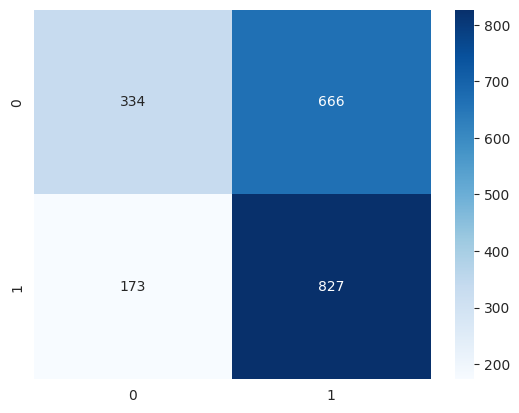

In [8]:
labels = [int(l) for l in dataset_df["semantic_clone"].to_list()]

print('Accuracy:', accuracy_score(labels, predictions))
print('F1 Score:', f1_score(labels, predictions))
print('Precision', precision_score(labels, predictions))
print('Recall', recall_score(labels, predictions))
print()

cf = confusion_matrix(labels, predictions, labels=[0, 1])
sns.heatmap(cf, annot=True, cmap='Blues', fmt="d")

# New tokenizer

In [7]:
from transformers import RobertaTokenizerFast, BatchEncoding
from tokenizers.processors import TemplateProcessing
model_name = "microsoft/codebert-base"

tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
# tokenizer._tokenizer.post_processor = TemplateProcessing(
#     single=tokenizer.bos_token + " $A " + tokenizer.eos_token,
#     pair=tokenizer.bos_token+" $A "+tokenizer.eos_token+" "+tokenizer.bos_token +" $B " +tokenizer.eos_token,
#     special_tokens=[(tokenizer.eos_token, tokenizer.eos_token_id), (tokenizer.bos_token, tokenizer.bos_token_id)],
# )

def tokenize_inputs(clones1, clones2):
    tokenized_inputs = tokenizer([clones1,clones2], padding="max_length", truncation=True, return_tensors="pt", max_length=400).to(device)
    # words1 = tokenizer.convert_ids_to_tokens(tokenized_inputs['input_ids'][0])
    tokenized_inputs.input_ids = torch.flatten(tokenized_inputs.input_ids)
    tokenized_inputs.attention_mask = torch.flatten(tokenized_inputs.attention_mask)
    return tokenized_inputs

In [11]:
remove_comments = False
predictions = []

for _,row_df in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
    print(row_df)
    tokenized = tokenize_inputs(row_df["clone1"], row_df["clone2"])
    prediction = model(tokenized.input_ids)
    prediction = int(torch.argmax(prediction[0]))
    predictions.append(prediction)

  0%|          | 0/2000 [00:00<?, ?it/s]

Unnamed: 0                                                        0
clone1            def second_largest(numbers) :\n\tcount = 0\n\t...
clone2            def second_largest(L) :\n\tif (len(L) < 2) :\n...
semantic_clone                                                    1
Name: 0, dtype: object


/home/luc/repos/zest/model.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob=F.softmax(logits)


Unnamed: 0                                                        1
clone1            def download_file(service, file_id) :\n\treque...
clone2            def download_file(file_id, mimeType, filename)...
semantic_clone                                                    1
Name: 1, dtype: object
Unnamed: 0                                                        2
clone1            def shift_n_letters(letter, n) :\n\tchar_array...
clone2            def shift_n_letters(letter, n) :\n\tn_ = n % 2...
semantic_clone                                                    1
Name: 2, dtype: object
Unnamed: 0                                                        3
clone1            def write(self, data) :\n\tif data [0 : LOG_ID...
clone2            def write(self, data) :\n\tself.stream.write(d...
semantic_clone                                                    1
Name: 3, dtype: object
Unnamed: 0                                                        4
clone1            def num_input(prompt, error) 

Accuracy: 0.576
F1 Score: 0.6599839615076183
Precision 0.5508701472556894
Recall 0.823


<Axes: >

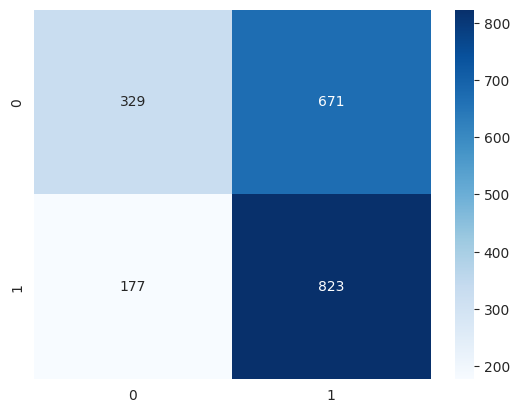

In [12]:
labels = [int(l) for l in dataset_df["semantic_clone"].to_list()]

print('Accuracy:', accuracy_score(labels, predictions))
print('F1 Score:', f1_score(labels, predictions))
print('Precision', precision_score(labels, predictions))
print('Recall', recall_score(labels, predictions))
print()

cf = confusion_matrix(labels, predictions, labels=[0, 1])
sns.heatmap(cf, annot=True, cmap='Blues', fmt="d")

# Some Tokenizer Tests

In [10]:
tokenized_new_c = tokenizer.encode_plus(
    text=row_df["clone1"],
    text_pair=row_df["clone2"],
    add_special_tokens=True,  # Add [CLS] and [SEP] tokens
    padding='max_length',     # Pad to the maximum length of the sequences
    max_length=512,           # Maximum length of the concatenated sequence
    return_tensors='pt'       # Return PyTorch tensors
)
c = tokenizer.convert_ids_to_tokens(tokenized_new_c["input_ids"][0])
c[128:133]

["('", '-', 'inf', "')", 'Ċ']

In [137]:
# Tokenizer Test: padding for each blogs, for me padding only at end
tokenized_old = convert_examples_to_features(row_df["clone1"], row_df["clone1"])
a = tokenizer.convert_ids_to_tokens(tokenized_old)
a[128:133]

['ĠTrue', '</s>', '<pad>', '<pad>', '<pad>']

In [136]:
tokenized_new = tokenize_inputs(row_df["clone1"], row_df["clone1"])
b = tokenizer.convert_ids_to_tokens(tokenized_new["input_ids"][0])
b[128:133]

['ĠTrue', '</s>', '<s>', 'def', 'Ġis']

In [155]:
none_pads = [s for i,s in enumerate(a) if s != '<pad>']

In [158]:
none_pads[:260] == c[:260]

True

In [11]:
device = torch.device("cpu")
for _,row_df in tqdm(dataset_df.iterrows(), total=len(dataset_df)):
    tokenized = convert_examples_to_features(row_df["clone1"], row_df["clone2"])
    
    tokenized2 = tokenize_inputs(row_df["clone1"], row_df["clone2"])
    
    is_same = torch.all(tokenized == tokenized2.input_ids)
    print(is_same)
    if not is_same:
        print(row_df)
        break

  0%|          | 0/2000 [00:00<?, ?it/s]

tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)